In [1]:
import numpy as np
from itertools import cycle
import os
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import json
import xesmf as xe
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
# os.chdir("/home/149/ab8992/cosima_regional/mom6-regional-scripts")
# import regional_library as ml
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40553,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:38413,Total threads: 2
Dashboard: /proxy/43417/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:34811,


In [2]:
expt_name = "sharkbay_iaf"
scratch = "/scratch/v45/jr5971"
home = "/home/581/jr5971"

# Import local copy of regional library
os.chdir(home+'/reg-scripts')
import regional_library as ml

## If using GLORYs, you'll need an email and password to access their database. make an account here: https://www.copernicus.eu/en/user/login?
pwd = "YOUR COPERNICUS PASSWORD"    
usr = "YOUR COPERNICUS USERNAME"  

In [3]:
%%capture
try:
    import xarray_leaflet
except:
    !pip install xarray_leaflet
    import xarray_leaflet
    
# additional script for access-specific slicing
from access_slicing import open_ryf_global, open_iaf_global, select_slice, time_rotate
from ipyleaflet import Map, basemaps
import json

In [4]:
# set paths
## Directory where you'll run the experiment from
rundir = f'{home}/mom6_rundirs/{expt_name}/'
## Place where all your input files go
inputdir = f'{scratch}/mom6_regional_configs/{expt_name}/'
## Place where temporary files are saved
tmpdir = f'{scratch}/regional_tmp/{expt_name}/'

## Directory where fre tools are stored ***JR NOTE: I don't have access to Angus' home directory :0 ***
# toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
toolpath = "/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/"

for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)

In [5]:
gridpath = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077/ocean/ocean_grid.nc"
glob = xr.open_dataset(gridpath)['ht'].rename({'yt_ocean':'y','xt_ocean':'x'})
aus_coords = {'W':-270,'E':-170,'S':-50,'N':0}
ausmap = glob.sel(x=slice(aus_coords['W'],aus_coords['E']), y=slice(aus_coords['S'], aus_coords['N']))
m = Map(center=[-30,160], zoom=3, basemap=basemaps.Esri.WorldImagery)
layer = ausmap.leaflet.plot(m)
ausmap.leaflet.select()
m

Url()

Map(center=[-30, 160], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

The `select()` method above allows to select a region by clicking and dragging a box on the map (first click on the █ button). 
The coordinates of the box are saved into the `tmpdir` for future reference, and the 10th degree bathymetry is plotted below...

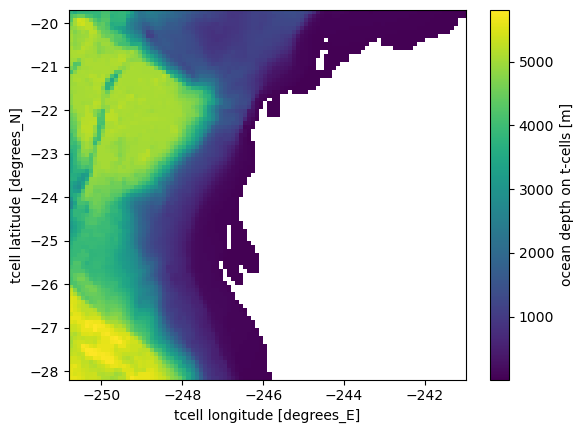

In [9]:
box = ausmap.leaflet.get_selection()
idx = {'W':np.float(box.x[0]), 'E':np.float(box.x[-1]), 
       'S':np.float(box.y[-1]), 'N':np.float(box.y[0])}
# Save domain coordinates for future reference
json_string = json.dumps(idx)
with open(tmpdir+'reg_coords.txt', 'w') as file:
    file.write(json_string)
idx
if box is not None:
    box.plot.imshow()

### Define forcing product, domain extent and date range

In [5]:
forcing_products = ["GLORYS", "ACCESS_RYF", "ACCESS_IAF"]
forcing = forcing_products[2]

# If re-opened notebook, load in domain coordinates from tmpdir
try:
    idx
    print("index already exists")
except: 
    with open(tmpdir+'reg_coords.txt','r') as file:
        idx_string = file.read()
    idx = json.loads(idx_string)
    print('found model coords')

## Choose your coordinates and the name of your experiment
yextent = [idx['S'],idx['N']]  ## latitude
xextent = [idx['W'], idx['E']] ## longitude

# for date, if ACCESS_RYF, daterange always 1990/91. Otherwise set manually (NOTE: could easily put this in expt with "forcing_product" as argument)
if forcing == "ACCESS_RYF":
    daterange = ["1991-01-01 12:00:00", "1991-12-31 12:00:00"]
elif forcing == "ACCESS_IAF":
    daterange = "set later"
else:
    daterange = ["2003-01-01 00:00:00", "2003-01-05 00:00:00"] ## 2003 is a good compimise for GLORYs and JRA forcing as they overlap. JRA ends in 2012, GLORYS starts in 1993


found model coords


# Step 2: Prepare ocean forcing data

We need to cut out our ocean forcing. The pipeline expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is "east_unprocessed" and "ic_inprocessed" for initial condition. Execute either of the following cells to pick GLORYs reanalysis or ACCESS OM2-01

## Option 2: ACCESS OM2-01

If you have access to where it's located on Gadi, you can execute the following cell to cut out and save your segments and use these instead.

**NOTE: I haven't automated this properly. You'll need to fiddle around with the 'for i in range(1077,1082)' line to choose the right year. Could maybe use COSIMA cookbook for this step instead?**

In [6]:
# Path to IAF Model output...
om2_iaf_cycle3 = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle3"
om2_iaf_cycle4 = "/g/data/ik11/tmp/01deg_jra55v140_iaf_cycle4/"
jra55v15_cycle1 = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1"

So, these are the paths to the global 10th degree IAF runs. These files are going to be huge. And we need to open them, slice them, and try to save upwards of 30 years of data for each slice. Let's just give it a go...

Actually, I just realised that we need an IAF run that has daily 3D outputs...
* `jra55v15_cycle1` has this!!

Now, options here are to ...
1. Group by year, then slice on individual years one at a time...
2. Try and brute force slice on the entire length. 
3. **Subset to just say 5 years, then try and slice over this as first try...**

In [7]:
om2_iaf, files = open_iaf_global()
files

['/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output051/ocean/ocean-3d-u-1-daily-mean-ym_1970_12.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output051/ocean/ocean-3d-u-1-daily-mean-ym_1970_10.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output051/ocean/ocean-3d-u-1-daily-mean-ym_1970_11.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-3d-u-1-daily-mean-ym_1970_03.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-3d-u-1-daily-mean-ym_1970_01.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-3d-u-1-daily-mean-ym_1970_02.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output049/ocean/ocean-3d-u-1-daily-mean-ym_1970_06.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output049/ocean/ocean-3d-u-1-daily-mean-ym_1970_05.nc',
 '/g/data/ik11/outputs/access-om2-01/01d

In [9]:
files.sort()
files

['/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-2d-eta_t-1-daily-mean-ym_1970_01.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-3d-salt-1-daily-mean-ym_1970_01.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-3d-salt-1-daily-mean-ym_1970_02.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-3d-salt-1-daily-mean-ym_1970_03.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-3d-temp-1-daily-mean-ym_1970_01.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-3d-temp-1-daily-mean-ym_1970_02.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-3d-temp-1-daily-mean-ym_1970_03.nc',
 '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output048/ocean/ocean-3d-u-1-daily-mean-ym_1970_01.nc',
 '/g/data/ik11/out

In [7]:
jra55v15_path = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hr'

In [23]:
%%time
year_range = range(1970,1975)

om2_iaf, files = open_iaf_global()
ic  = om2_iaf.isel(time=0)
ic = ic.sel(
    yt_ocean = slice(yextent[0]-0.2, yextent[1]+0.2),
    yu_ocean = slice(yextent[0]-0.2, yextent[1]+0.2),
    xt_ocean = slice(xextent[0]-0.2, xextent[1]+0.2),
    xu_ocean = slice(xextent[0]-0.2, xextent[1]+0.2))
ic.to_netcdf(tmpdir+'ic_unprocessed.nc')
print('finished saving initial conditions')

for bound in ['east', 'west','north', 'south']:
    edge = select_slice(d=om2_iaf, borders=[yextent,xextent], boundary=bound)
    print(f'{bound} slice selected')
    print('now saving ...')
    edge.to_netcdf(tmpdir+f'{bound}_unprocessed.nc')
    print(f'finished saving {bound}ern boundary inputs')

CPU times: user 787 ms, sys: 97.2 ms, total: 884 ms
Wall time: 1.63 s


## JRA55 IAF FORCING
The plan here is as follows:
1. Test run: Select all files for 1970 and place these into a new forcing folder with the `inputdir`. 
2. Make this automated, such that it calls the next-years forcing files automatically

In [12]:
jra55v15_path = "/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0"

In [13]:
# get all file paths that have 1970 in them
filepaths = []
matching_paths = glob.glob(f"{jra55v15_path}/**/*1970*", recursive=True)
filepaths.extend(matching_paths)


In [14]:
matching_paths

['/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/seaIce/3hrPt/siconca/gr/v20200916/siconca_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_197001010000-197012312100.nc',
 '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/seaIce/day/siconc/gn/v20200916/siconc_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gn_19700101-19701231.nc',
 '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hrPt/uas/gr/v20200916/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_197001010000-197012312100.nc',
 '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hrPt/tas/gr/v20200916/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_197001010000-197012312100.nc',
 '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hrPt/ts/gr/v20200916/ts_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_197001010000-197012312100.nc',
 '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JR

In [17]:
os.mkdir(inputdir+'jra_forcing')

In [20]:
jra_path = inputdir + 'jra_forcing/'
jra_path

'/scratch/v45/jr5971/mom6_regional_configs/sharkbay_iaf/jra_forcing/'

In [21]:
import shutil

In [22]:
for file in filepaths:
    shutil.copy(f"{file}", jra_path)

In [39]:
tas_ryf = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.t_10.1990_1991.nc')
tas_iaf = xr.open_dataset('/scratch/v45/jr5971/mom6_regional_configs/sharkbay_iaf/jra_forcing/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_197001010000-197012312100.nc')
print(f"tas_ryf timestart: {tas_ryf.time.min().values} | tas_iaf timestart: {tas_iaf.time.min().values}")

tas_ryf timestart: 1900-01-01 00:00:00 | tas_iaf timestart: 1970-01-01T00:00:00.000000000


In [41]:
rlds_ryf = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.rlds.1990_1991.nc')
rlds_iaf = xr.open_dataset('/scratch/v45/jr5971/mom6_regional_configs/sharkbay_iaf/jra_forcing/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_197001010130-197012312230.nc')
print(f"tas_ryf timestart: {tas_ryf.time.min().values} | tas_iaf timestart: {tas_iaf.time.min().values}")

tas_ryf timestart: 1900-01-01 00:00:00 | tas_iaf timestart: 1970-01-01T00:00:00.000000000


NOTE: The ic wouldn't save when files opened with `decode_times=True` - when attempting to save, `KeyError: days since 1900-01-01 00:00:00` or something like that...

# Step 3: Make experiment object
This object keeps track of your domain basics, as well as generating the hgrid, vgrid and setting up the folder structures. 

After running you can have a look at your grids by calling expt.hgrid and expt.vgrid

Plotting vgrid with marker = '.' option lets you see the spacing, or plotting np.diff(expt.hgrid.zl).plot(marker = '.') shows you the vertical spacing profile.

## Modular workflow!

After constructing your expt object, if you don't like my lazy default hgrid and vgrid you can simply modify and overwrite them. However, you'll also need to save them to disk again as I've not automated this just yet. For example:

expt.hgrid = custom_hgrid
expt.hgrid.to_netcdf(f"{inputdir}/hgrid.nc")

In [7]:
toolpath = '/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/'

In [14]:
year_range = range(1970,1975)

In [16]:
# for iaf access..
daterange = [f'{year_range[0]}-01-01 00:00:00',f'{year_range[-1]}-12-31 00:00:00']
expt = ml.experiment(
    xextent,
    yextent,
    daterange,
    0.05,  # Resolution
    75,    # Number of vertical layers
    10,    # Ratio of largest to smallest vertical layer. Select 1 for linear, negative number for higher resolution at bottom
    4500,  # Depth of simulation
    rundir,
    inputdir,
    toolpath
)

i=0, xb1=-251.6500000000, xb2=-243.3500000000, dx=-171.7000000000
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congratulation: You have successfully run make_solo_mosaic
FRE TOOLS: Make solo mosaic


CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


ln: failed to create symbolic link '/home/581/jr5971/mom6_rundirs/sharkbay_iaf//inputdir/sharkbay_iaf': File exists
ln: failed to create symbolic link '/scratch/v45/jr5971/mom6_regional_configs/sharkbay_iaf//rundir/sharkbay_iaf': File exists


# Step 4: Set up bathymetry

Similarly to ocean forcing, we point our 'bathymetry' method at the location of the file of choice, and pass it a dictionary mapping variable names. This time we don't need to preprocess the topography since it's just a 2D field and easier to deal with. Afterwards you can run `expt.topog` and have a look at your domain. After running this cell, your input directory will contain other topography - adjacent things like the ocean mosaic and mask table too. This defaults to a 10x10 layout which can be updated later.

In [10]:
expt.bathymetry(
    '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    {"xh":"lon",
     "yh":"lat",
     "elevation":"elevation"}, ## Again this dictionary just maps mom6 variable names to what they are in your topog.
     minimum_layers = 1
    )

 Starting weight generation with these inputs: 
   Source File: bathy_original.nc
   Destination File: topog_raw.nc
   Source variable names: elevation
   Destination variable names: elevation
   Souce Grid has a mask, using missingvalue    1.0000000000000000E+020
   Source File is in GRIDSPEC format with coordinate names lon lat
   Source Grid is a regional grid
   Destination File is in GRIDSPEC format with coordinate names lon lat
   Destination Grid is a regional grid
   Regrid Method: bilinear
   Pole option: NONE

 Completed file regrid successfully.

i=0, xb1=-251.6500000000, xb2=-243.3500000000, dx=-171.7000000000
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congratulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC

CompletedProcess(args='/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC

CompletedProcess(args='/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
model = ocean
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (solo mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_

### Check out your domain:

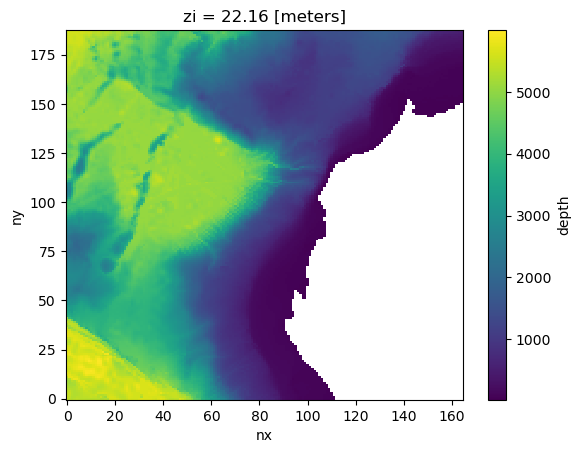

In [11]:
expt.topog.depth.plot()

#  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the mom6 variable names to what they're called in your ocean input file. Notice how for GLORYs, the horizontal dimensions are x and y, vs xh, yh, xq, yq for ACCESS OM2-01. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations. 

### **Note: Only run one of the two cells below according to what forcing you chose!**

In [ ]:
## FOR GLORYS: 
expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time",
     "y":"latitude",
     "x":"longitude",
     "zl":"depth",
     "eta":"zos",
     "u":"uo",
     "v":"vo",
     "tracers":{"salt":"so",
                "temp":"thetao"
                }
    },
    boundaries = ["south","north","west","east"],
    gridtype="A"
)

In [10]:
%%time
## FOR ACCESS OM2: 
expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time",
     "yh":"yt_ocean",
     "xh":"xt_ocean",
     "xq":"xu_ocean",
     "yq":"yu_ocean",
     "zl":"st_ocean",
     "eta":"eta_t",
     "u":"u",
     "v":"v",
     "tracers":{"salt":"salt","temp":"temp"}},
    boundaries = ["south","north","west","east"],
    gridtype="B"
    )

INITIAL CONDITIONS
Regridding Velocities...Done.
Regridding Tracers...
Done.
Regridding Free surface...
Saving outputs... done.
BRUSHCUT BOUNDARIES
Processing south...Done.
Processing north...Done.
Processing west...Done.
Processing east...Done.
CPU times: user 4min 1s, sys: 29.2 s, total: 4min 30s
Wall time: 4min 19s


# Step 6 (optional) Select number of processors 

This is just a wrapper for check_mask FRE tool. Choose the number of processors in the X and Y directions respectively

In [19]:
expt.processor_mask((10,10))


 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
model = ocean
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (solo mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE from get_boundary_type: y_boundary_type is solid_walls

==>NOTE from check_mask: Checking for possible masking:
==>NOTE from check_mask: Assume 4 halo rows
==>NOTE from check_mask: Total domain size is 165, 188

_______________________________________________________________________

NOTE from check_mask: The following is for using model source code with version older than siena_201207,
Possible setting to mas

## Step 7 Regrid the runoff 

 This step will be removed in a future update when this functionality is added to rest of pipeline. Currently it calls a function from the legacy regional_model_scripts file. Just execute cell to give your domain runoff from JRA in 1991. Rivers do the same thing every year right?


In [25]:
runoff_path = jra_path + "friver_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_19700101-19701231.nc"
runoff_raw = xr.open_dataset(runoff_path)

In [27]:
runoff_path = "/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc" ## Can change to match your year
runoff_ryf = xr.open_dataset(runoff_path)
runoff_ryf

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, time: 365)
Coordinates:
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) object 1900-01-01 00:00:00 ... 1900-12-31 00:00:00
Data variables:
    friver     (time, latitude, longitude) float32 ...
Attributes:
    title:        River runoff into the ocean of JRA55-do
    institution:  JMA Meteorological Research Institute
    comment:      River routing model CaMaFlood forced by JRA-55 runoff from ...
    version:      v1.1
    fill_value:   Fill value is -9.99e33

In [32]:
friver = runoff_raw['friver']
friver_renamed = friver.rename({'lat':'latitude','lon':'longitude'})
friver_renamed

<xarray.DataArray 'friver' (time: 365, latitude: 720, longitude: 1440)>
[378432000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1970-01-01T12:00:00 ... 1970-12-31T12:00:00
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Attributes:
    standard_name:  water_flux_into_sea_water_from_rivers
    long_name:      Water Flux into Sea Water from Rivers
    comment:        computed as the river flux of liquid water into the ocean...
    units:          kg m-2 s-1
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello

In [37]:
friver_renamed.to_netcdf(jra_path+'friver.nc')

In [38]:
from regional_model_scripts import regrid_runoff
# runoff_path = "/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc" ## Can change to match your year
# runoff_path = jra_path + "friver_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_19700101-19701231.nc"
runoff_path = jra_path + 'friver.nc'

regrid_runoff(inputdir + "ocean_mask.nc",
    inputdir + "hgrid.nc",
    runoff_path,
    inputdir + "runoff_regrid.nc",
    # np.array(xextent) - np.array([180,180]),
    xextent,
    yextent)

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 34, longitude: 34)
Coordinates:
  * time       (time) datetime64[ns] 1970-01-01T12:00:00 ... 1970-12-31T12:00:00
  * latitude   (latitude) float64 -27.12 -26.88 -26.62 ... -19.38 -19.12 -18.88
  * longitude  (longitude) float64 108.4 108.6 108.9 109.1 ... 116.1 116.4 116.6
Data variables:
    friver     (time, latitude, longitude) float32 ...


# Step 8: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This cell just copies a default run directory and modifies it to match your configuration.

In [17]:
# define project for config.yaml: e.g., x77 | v45 |...
project = "v45"
if project == "v45":
    mom6_exe = "/g/data/v45/mom/symmetric_FMS2-e7d09b7"
elif project == "x77":
    mom6_exe = "/g/data/x77/ahg157/exes/MOM6_SIS2/symmetric_FMS2-e7d09b7"
else:
    pass

In [21]:
project

'v45'

In [20]:
subprocess.run(f"cp default_rundir/jra_surface/* {rundir} -r",shell = True)
# subprocess.run(f"cp default_rundir/era5_surface/* {rundir} -r",shell = True)
subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)

hgrid = xr.open_dataset(f"{inputdir}/hgrid.nc")

## Get mask table information
ncpus = 10
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'

    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n" 

        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "project" in lines[i]:
        lines[i] = f'project: {project}\n'
    if "shortpath" in lines[i]:
        lines[i] = f"shortpath: /scratch/{project}"
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"
    if "exe:" in lines[i]:
        lines[i:i+3] = f"exe: {mom6_exe}\n"
    if "storage:" in lines[i]:
        lines[i+1:i+5] = f"  gdata:\n    - ua8\n    - {project}\n    - ik11"

inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()


# Modify input.nml 
inputfile = open(f"{rundir}/input.nml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "current_date" in lines[i]:
        tmp = daterange[0].split(" ")[0].split("-")
        lines[i] = f"{lines[i].split(' = ')[0]} = {int(tmp[0])},{int(tmp[1])},{int(tmp[2])},0,0,0,\n"

 
inputfile = open(f"{rundir}/input.nml",'w')
inputfile.writelines(lines)
inputfile.close()


ln: failed to create symbolic link '/home/581/jr5971/mom6_rundirs/sharkbay_iaf//inputdir/sharkbay_iaf': File exists


# BONUS! Want to use ERA5 surface forcing instead?

This is WIP and not tested but thought I'd include it

## SET UP ERA5 forcing:
Here we take the ERA forcing as it already exists on Gadi. For NCI users, you need access to the rt group. ERA5 - specific functions provided cut out the region of interest and fix up the metadata ready for MOM6.

For this example, we are forcing for the entire year of 2015 so we just generate a single forcing file with 2015's data.

Below is a table showing ERA5 characteristics and what needs to be done to sort it out
### Required ERA data:
Name | ERA filename | era variable name | notes
---|---|---|---
Surface Pressure | sp | sp | Pa :heavy_check_mark:
Surface Temperature | 2t | t2m | K :heavy_check_mark:
Meridional Wind | 10v | v10 | m/s :heavy_check_mark:
Zonal Wind | 10u | u10 | m/s :heavy_check_mark:
Specific Humidity | na | na | kg/kg, calculated from dewpoint temperature
Dewpoint Temperature | 2d | d2m | K


We can calculate specific humidity $q$ from dewpoint temperature $T_d$ and surface pressure $P$ via saturation vapour pressure $P_v$.

$\large P_v = 10^{8.07131 - \frac{1730.63}{233.426 + T}} \frac{101325}{760} $ Pascals

$\large q = 0.001 * 0.622  \frac{P_v}{P}$ 

In [ ]:
#! Messy Work in progress for now but works. I think there's an issue with specific humidity units?

erapath = "/g/data/rt52/era5/single-levels/reanalysis"

## Firstly just open all raw data
rawdata = {}
for fname , vname in zip(["2t","10u","10v","sp","2d"] , ["t2m","u10","v10","sp","d2m"]):

    rawdata[fname] = ml.nicer_slicer(
        xr.open_mfdataset(f"{erapath}/{fname}/{daterange[0].split('-')[0]}/{fname}*",decode_times = False,chunks = {"longitude":100,"latitude":100}),
        xextent,
        "longitude"
    ).sel(
        latitude = slice(yextent[1],yextent[0]) ## This is because ERA5 has latitude in decreasing order (??)
    )

    ## Now fix up the latitude and time dimensions

    rawdata[fname] = rawdata[fname].isel(
        latitude = slice(None,None,-1) ## Flip latitude        
        ).assign_coords(
        time = np.arange(0,rawdata[fname].time.shape[0],dtype=float) ## Set the zero date of forcing to start of run
        )
    

    

    rawdata[fname].time.attrs = {"calendar":"julian","units":f"hours since {daterange[0]}"} ## Fix up calendar to match

    if fname == "2d":
        ## Calculate specific humidity from dewpoint temperature 
        q = xr.Dataset(
            data_vars= {
                "q": 0.001 * (0.622 / rawdata["sp"]["sp"]) * (10**(8.07131 - 1730.63 / (233.426 + rawdata["2d"]["d2m"]))) * 101325 / 760
                }

        )
        q.q.attrs = {"long_name":"Specific Humidity","units": "kg/kg"}
        q.to_netcdf(f"{inputdir}/forcing/q_ERA5",unlimited_dims = "time",encoding = {"q":{"dtype":"double"}})
    else:
        rawdata[fname].to_netcdf(f"{inputdir}/forcing/{fname}_ERA5",unlimited_dims = "time",encoding = {vname:{"dtype":"double"}})


## Update the data table to match:

subprocess.run(f"cp default_rundir/era5_surface/data_table {rundir}/data_table",shell = True)




